# PTB Benchmark Analysis

Analysis of precover decomposition benchmark results on the PTB tokenizer FST.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Find available result files
results_dir = Path('../output')
json_files = sorted(results_dir.glob('ptb*.json'))
print(f"Available: {[f.name for f in json_files]}")

# Use the most recent, or change manually
RESULTS_FILE = json_files[-1] if json_files else None
print(f"Using: {RESULTS_FILE}")

Available: ['ptb_benchmark.json', 'ptb_rust_full.json', 'ptb_rust_full_paragraph.json']
Using: ../output/ptb_rust_full_paragraph.json


In [2]:
# Load results
with open(RESULTS_FILE) as f:
    data = json.load(f)

print("Config:")
for k, v in data['config'].items():
    print(f"  {k}: {v}")

print("\nFST stats:")
for k, v in data['fst_stats'].items():
    print(f"  {k}: {v}")

Config:
  n_paragraphs: 1
  max_chars: None
  max_prefix_len: 50
  methods: ['rust']
  timeout_sec: 60.0

FST stats:
  states: 161
  input_alphabet: 257
  output_alphabet: 254


In [3]:
# Convert to DataFrame
df = pd.DataFrame(data['results'])
df['time_sec'] = df['time_ms'] / 1000
df['q_arc_density'] = df['quotient_arcs'] / df['quotient_states'].replace(0, 1)

print(f"Rows: {len(df)}, Methods: {df['method'].unique().tolist()}")
print(f"Prefix lengths: {df['target_len'].min()} to {df['target_len'].max()}")
df.head()

Rows: 50, Methods: ['rust']
Prefix lengths: 1 to 50


,paragraph,method,time_ms,quotient_states,quotient_final,quotient_arcs,remainder_states,remainder_final,remainder_arcs,target_len,time_sec,q_arc_density
0,1,rust,29.118829,3,1,4,3,0,4,1,0.029119,1.333333
1,1,rust,30.860661,5,1,8,5,0,8,2,0.030861,1.600000
2,1,rust,29.479526,7,1,12,7,0,12,3,0.029480,1.714286
3,1,rust,29.837723,9,1,16,9,0,16,4,0.029838,1.777778
4,1,rust,29.614098,11,1,20,11,0,20,5,0.029614,1.818182


## Overview

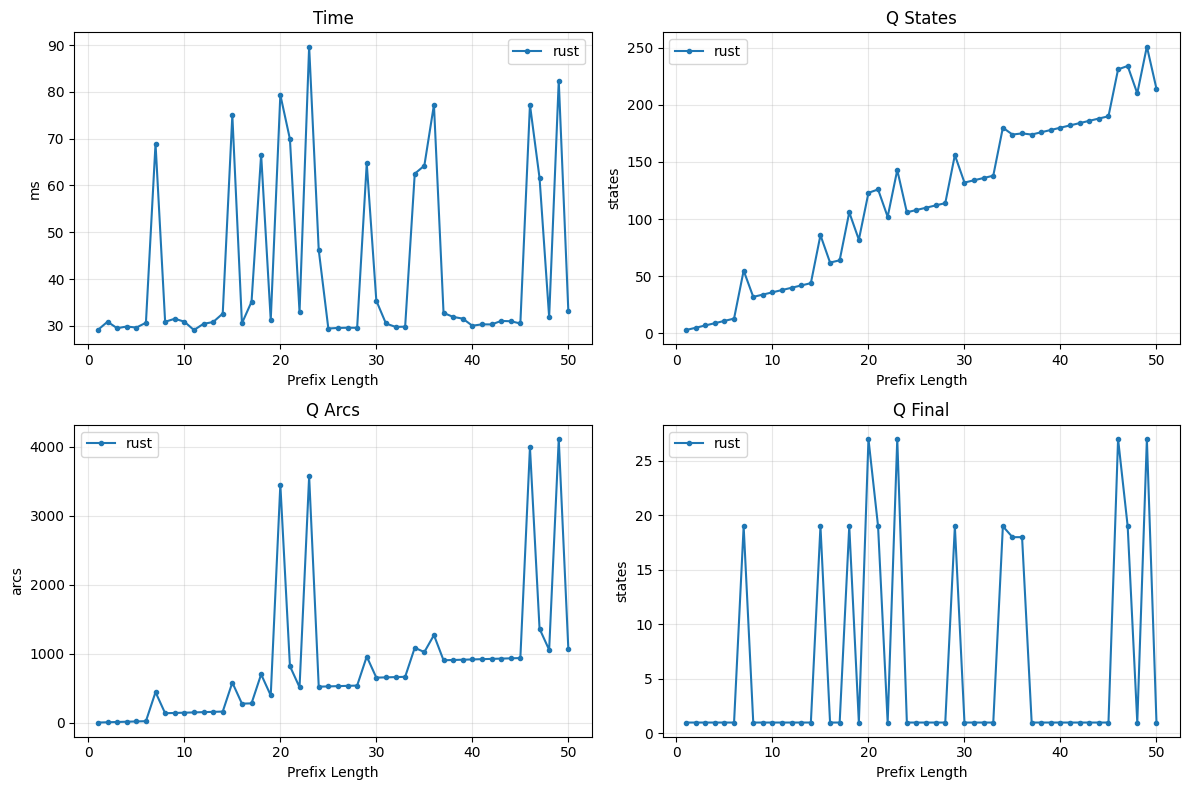

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for method in df['method'].unique():
    s = df[df['method'] == method]
    axes[0,0].plot(s['target_len'], s['time_ms'], 'o-', label=method, markersize=3)
    axes[0,1].plot(s['target_len'], s['quotient_states'], 'o-', label=method, markersize=3)
    axes[1,0].plot(s['target_len'], s['quotient_arcs'], 'o-', label=method, markersize=3)
    axes[1,1].plot(s['target_len'], s['quotient_final'], 'o-', label=method, markersize=3)

for ax, title, ylabel in [(axes[0,0], 'Time', 'ms'), (axes[0,1], 'Q States', 'states'),
                          (axes[1,0], 'Q Arcs', 'arcs'), (axes[1,1], 'Q Final', 'states')]:
    ax.set_xlabel('Prefix Length')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()

## Scaling

In [5]:
for method in df['method'].unique():
    s = df[df['method'] == method]
    x = s['target_len'].values
    
    c_states = np.polyfit(x, s['quotient_states'].values, 1)
    c_arcs = np.polyfit(x, s['quotient_arcs'].values, 1)
    c_time = np.polyfit(x, s['time_ms'].values, 1)
    
    print(f"{method}:")
    print(f"  Q states ≈ {c_states[0]:.2f} * len + {c_states[1]:.1f}")
    print(f"  Q arcs   ≈ {c_arcs[0]:.2f} * len + {c_arcs[1]:.1f}")
    print(f"  Time     ≈ {c_time[0]:.2f} * len + {c_time[1]:.1f} ms")

rust:
  Q states ≈ 4.71 * len + -3.9
  Q arcs   ≈ 34.78 * len + -51.9
  Time     ≈ 0.21 * len + 36.7 ms


## Summary

In [6]:
df.groupby('method').agg({
    'time_ms': ['mean', 'min', 'max'],
    'quotient_states': ['mean', 'min', 'max'],
    'quotient_final': ['mean', 'min', 'max'],
    'remainder_final': ['sum'],
}).round(1)

time_ms             quotient_states          quotient_final          \
          mean   min   max            mean min  max           mean min max   
method                                                                       
rust      42.0  29.1  89.7           116.3   3  251            6.3   1  27   

       remainder_final  
                   sum  
method                  
rust                52

## Remainder Analysis

In [7]:
non_empty = df[df['remainder_final'] > 0]
if len(non_empty) == 0:
    print("✓ Remainder always empty (all precover strings are cylinders)")
else:
    print(f"Found {len(non_empty)} cases with non-empty remainder:")
    print(non_empty[['method', 'target_len', 'quotient_final', 'remainder_final']])

Found 4 cases with non-empty remainder:
   method  target_len  quotient_final  remainder_final
19   rust          20              27               13
22   rust          23              27               13
45   rust          46              27               13
48   rust          49              27               13


## Time Spikes

In [8]:
for method in df['method'].unique():
    s = df[df['method'] == method]
    median = s['time_ms'].median()
    spikes = s[s['time_ms'] > median * 1.5]
    print(f"{method}: median={median:.1f}ms, {len(spikes)} spikes")
    for _, r in spikes.head(5).iterrows():
        print(f"  len={r['target_len']}: {r['time_ms']:.1f}ms, Q_final={r['quotient_final']}")

rust: median=31.1ms, 13 spikes
  len=7: 69.0ms, Q_final=19
  len=15: 75.0ms, Q_final=19
  len=18: 66.6ms, Q_final=19
  len=20: 79.4ms, Q_final=27
  len=21: 69.9ms, Q_final=19


---
# Audit: Inspect Individual Automata

Run decomposition at a specific prefix and visualize Q/R.

In [ ]:
# Setup: Build PTB FST and load text
import sys
sys.path.insert(0, '..')

from transduction.applications.ptb import build_ptb_fst_pynini, string_to_byte_strs, SEP
from benchmark.data import load_wikitext, wikitext_detokenize
from transduction.fst import FST
from transduction.fsa import EPSILON
from transduction.rust_bridge import RustDecomp

print("Building PTB FST...")
ptb_fst = build_ptb_fst_pynini()

# Load first paragraph
for item in load_wikitext("test"):
    text = item["text"].strip()
    if text and not text.startswith("="):
        break

detok = wikitext_detokenize(text)
output_fsa = (FST.from_string(string_to_byte_strs(detok)) @ ptb_fst).project(1)
target_full = next(output_fsa.language(tuple=True))

print(f"Text: {detok[:80]}...")
print(f"Total symbols: {len(target_full)}")

In [10]:
# Run decomposition - change PREFIX_LEN to inspect different positions
# Try: 20, 23, 46, 49 for non-empty remainder cases
PREFIX_LEN = 20

target = target_full[:PREFIX_LEN]
result = RustDecomp(ptb_fst, target)
Q, R = result.quotient, result.remainder

# Decode target
tokens = []
buf = []
for sym in target:
    if sym == SEP:
        if buf: tokens.append(bytes([int(b) for b in buf]).decode('utf-8', errors='replace'))
        buf = []
    elif sym != EPSILON:
        buf.append(sym)
if buf: tokens.append(bytes([int(b) for b in buf]).decode('utf-8', errors='replace'))

print(f"Prefix {PREFIX_LEN}: {' | '.join(tokens)}")
print(f"Q: {len(Q.states)} states, {len(Q.stop)} final")
print(f"R: {len(R.states)} states, {len(R.stop)} final")

Prefix 20: Robert | Boulter | is | an
Q: 103 states, 27 final
R: 103 states, 5 final


In [11]:
# Symbol formatter for readable graphviz output
def fmt_sym(s):
    """Convert byte symbol to readable string."""
    if s == EPSILON:
        return 'ε'
    try:
        i = int(s)
        if i == 32:
            return '␣'  # visible space
        return repr(bytes([i]))[2:-1]  # e.g. 'a', '\\n', '\\x00'
    except:
        return str(s)

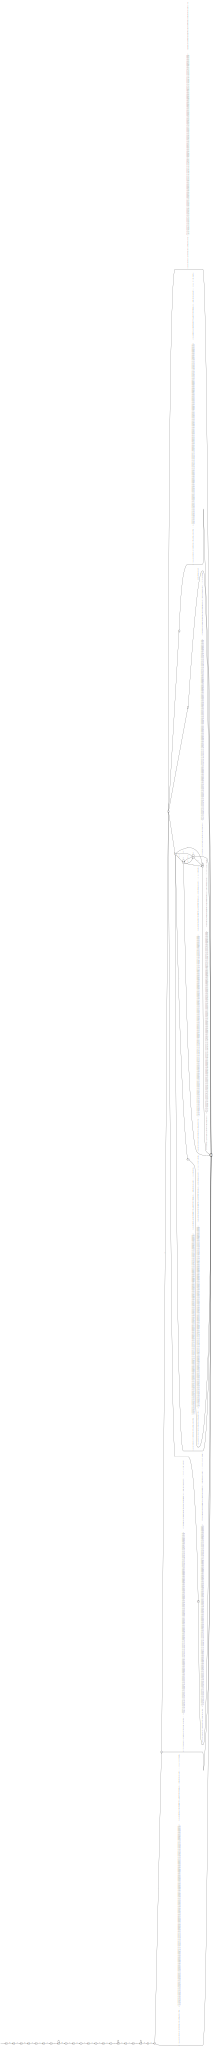

In [22]:
QQ = Q.min()#trim()
# Visualize Q (if small enough)
if len(QQ.states) <= 150:
    display(QQ.graphviz(fmt_edge=lambda i, a, j: fmt_sym(a)))
else:
    print(f"Q too large ({len(QQ.states)} states) - showing stats only")

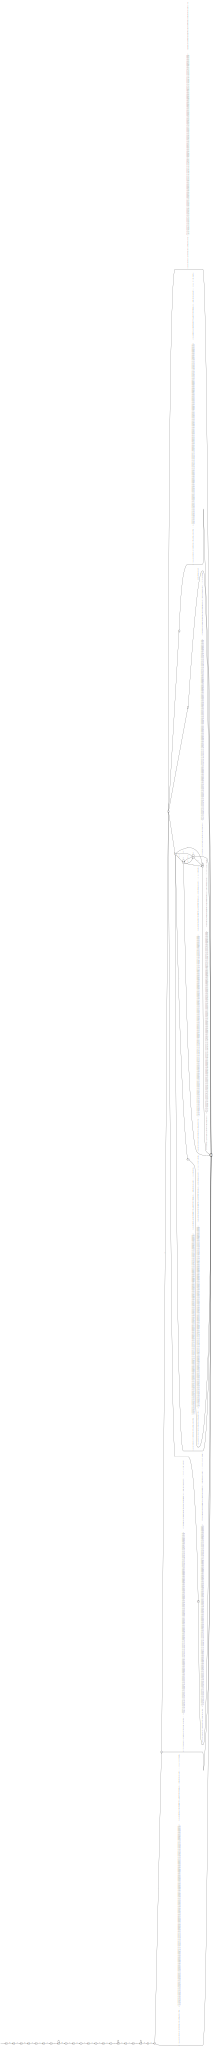

In [25]:
from transduction import FSA
QQ.graphviz(fmt_edge=lambda i, a, j: fmt_sym(a))

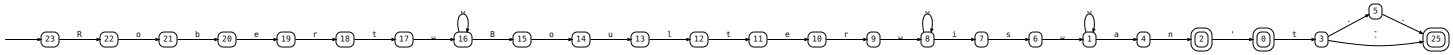

In [20]:
# Visualize R (if small enough)
R_trim = R.min()#trim()
if len(R_trim.states) <= 100:
    display(R_trim.graphviz(fmt_edge=lambda i, a, j: fmt_sym(a)))
else:
    print(f"R too large ({len(R_trim.states)} states) - showing stats only")

In [ ]:
t = 0
for x in R_trim.language(tuple=True):
    t += 1
    if t > 1000: break
    print(''.join(fmt_sym(y) for y in x))

In [ ]:
from transduction import FSA
tmp = FSA(start=R_trim.start, arcs=[(i,a,j) for i,a,j in R_trim.arcs() if a != '0' and a != '3'], stop=R_trim.stop)
tmp.graphviz(fmt_edge=lambda i, a, j: fmt_sym(a))

In [ ]:
t = 0
for x in tmp.language(tuple=True):
    t += 1
    if t > 100000: break
    print(''.join(fmt_sym(y) for y in x))

In [ ]:
from itertools import islice

def enum_strings(fsa, max_n=5):
    return [''.join(fmt_sym(x) for x in path) for path in islice(fsa.language(tuple=True), max_n)]

print(f"Q strings (cylinders, {len(Q.stop)} final):")
for s in enum_strings(Q): print(f"  {repr(s)}")

print(f"\nR strings (non-cylinders, {len(R.stop)} final):")
for s in enum_strings(R): print(f"  {repr(s)}")